In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE

import xgboost as xgb

import joblib

In [2]:
df = pd.read_csv('../data/raw/ai4i_predictive_maintenance.csv')
print("Shape:", df.shape)
print(df.columns.tolist())

Shape: (10000, 14)
['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


In [3]:
drop_cols = ['UDI', 'Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df = df.drop(columns=drop_cols)
print("After drop:", df.shape)

After drop: (10000, 7)


In [4]:
df = pd.get_dummies(df, columns=['Type'], drop_first=True)
print("Columns now:", df.columns.tolist())

Columns now: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'Type_L', 'Type_M']


In [5]:
X = df.drop(columns=['Machine failure'])
y = df['Machine failure']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (10000, 7)
y shape: (10000,)


In [6]:
print("Class distribution:")
print(y.value_counts(normalize=True).round(4) * 100)

Class distribution:
Machine failure
0    96.61
1     3.39
Name: proportion, dtype: float64


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape)
print("Test :", X_test.shape)

Train: (8000, 7)
Test : (2000, 7)


In [8]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("After SMOTE train shape:", X_train_sm.shape)
print("Balanced classes:\n", pd.Series(y_train_sm).value_counts())

After SMOTE train shape: (15458, 7)
Balanced classes:
 Machine failure
0    7729
1    7729
Name: count, dtype: int64


In [9]:
lr = LogisticRegression(max_iter=2000, random_state=42)
lr.fit(X_train_sm, y_train_sm)

pred_lr = lr.predict(X_test)

print("Logistic Regression:")
print(classification_report(y_test, pred_lr))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1932
           1       0.17      0.72      0.27        68

    accuracy                           0.87      2000
   macro avg       0.58      0.80      0.60      2000
weighted avg       0.96      0.87      0.91      2000



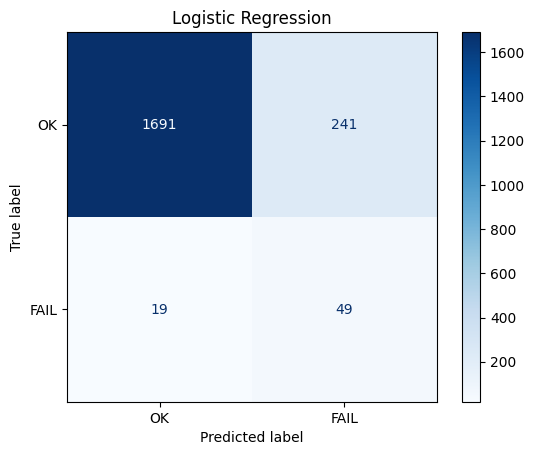

In [10]:
ConfusionMatrixDisplay.from_predictions(
    y_test, pred_lr,
    display_labels=['OK', 'FAIL'],
    cmap='Blues'
)
plt.title("Logistic Regression")
plt.show()

In [11]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_sm, y_train_sm)

pred_rf = rf.predict(X_test)

print("Random Forest:")
print(classification_report(y_test, pred_rf))

Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1932
           1       0.36      0.72      0.48        68

    accuracy                           0.95      2000
   macro avg       0.67      0.84      0.72      2000
weighted avg       0.97      0.95      0.96      2000



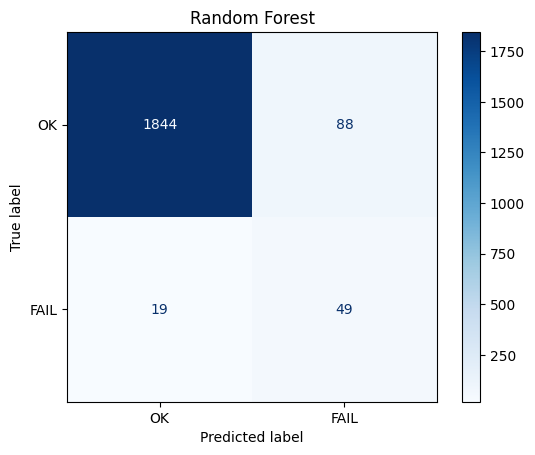

In [12]:
ConfusionMatrixDisplay.from_predictions(
    y_test, pred_rf,
    display_labels=['OK', 'FAIL'],
    cmap='Blues'
)
plt.title("Random Forest")
plt.show()

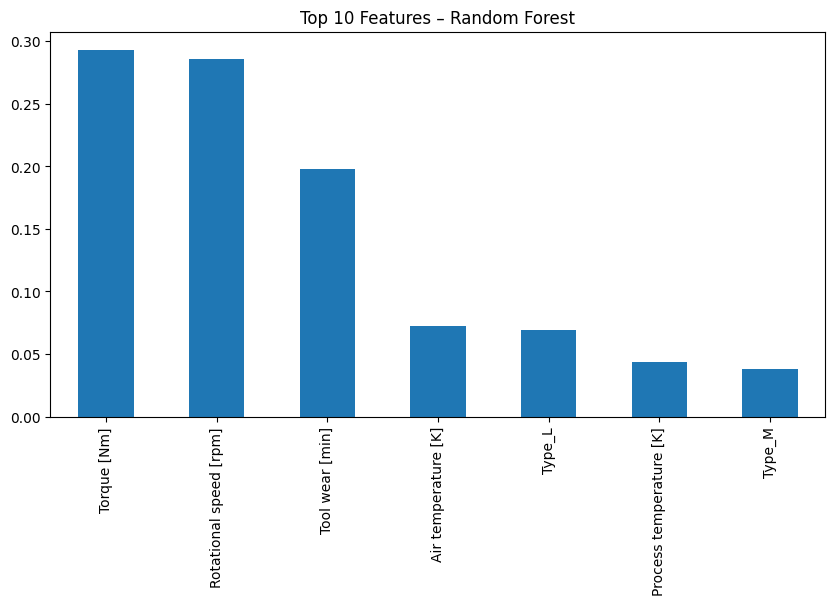

In [13]:
pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False).head(10).plot.bar(figsize=(10,5))

plt.title("Top 10 Features – Random Forest")
plt.show()

In [14]:
joblib.dump(rf, '../models/baseline_randomforest.pkl')
print("Model saved")

Model saved
